# PyTorch Regression Tutorial

This tutorial demonstrates a simple linear regression using PyTorch.
We'll predict house prices using the California Housing dataset.

**Learning Objectives:**
- Understand basic PyTorch workflow
- Build a simple neural network for regression
- Train and evaluate the model
- Visualize results

## 1. Import Libraries

Import necessary libraries for data processing, model building, and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else
                      "cpu")
device


device(type='mps')

## 2. Load and Explore Data

Load the California Housing dataset and explore its structure.

In [8]:
# 1. 필수 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Student_Performance.csv')
df.columns = df.columns.str.replace(' ', '_')
df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map({'Yes': 1, 'No': 0})

# Extract features and target
X = df.drop('Performance_Index', axis=1).values
y = df['Performance_Index'].values

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {df.drop('Performance_Index', axis=1).columns.tolist()}")
print(f"Target: Performance Index (score from 0-100)")

# Display statistics
print(f"\nTarget statistics (Performance Index):")
print(f"  Min: {y.min():.2f} points")
print(f"  Max: {y.max():.2f} points")
print(f"  Mean: {y.mean():.2f} points")

Dataset Information:
Number of samples: 10000
Number of features: 5

Feature names: ['Hours_Studied', 'Previous_Scores', 'Extracurricular_Activities', 'Sleep_Hours', 'Sample_Question_Papers_Practiced']
Target: Performance Index (score from 0-100)

Target statistics (Performance Index):
  Min: 10.00 points
  Max: 100.00 points
  Mean: 55.22 points


## 3. Data Preprocessing

Split the data into training and test sets, and normalize features for better training performance.

In [9]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

Training set size: 8000 samples
Test set size: 2000 samples

✓ Data normalized (mean=0, std=1)


## 4. Convert to PyTorch Tensors

Convert NumPy arrays to PyTorch tensors and create DataLoaders for batch processing.

In [10]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 125
Number of test batches: 32


## 5. Model Definition

Define a simple feedforward neural network for regression.

**Architecture:**
- Input layer: 8 features
- Hidden layer 1: 64 neurons with ReLU activation
- Hidden layer 2: 32 neurons with ReLU activation
- Output layer: 1 neuron (predicted house price)

In [11]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer
        
    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: mps


## 6. Loss Function and Optimizer

Define the loss function and optimizer for training.

- **Loss Function:** Mean Squared Error (MSE) - standard for regression
- **Optimizer:** Adam - adaptive learning rate optimizer

In [12]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


## 7. Training Loop

Train the model and track the loss over epochs.

**Training Process:**
1. Forward pass: compute predictions
2. Compute loss: compare predictions with true values
3. Backward pass: compute gradients
4. Update weights: optimize parameters

In [13]:
# Training parameters
num_epochs = 100

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 1. Forward pass: compute predictions
        predictions = model(X_batch)
        
        # 2. Compute loss
        loss = criterion(predictions, y_batch)
        
        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients
        
        # 4. Update weights
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 7.4803 | Test Loss: 6.8906
Epoch [20/100] | Train Loss: 4.4453 | Test Loss: 4.5067
Epoch [30/100] | Train Loss: 4.3315 | Test Loss: 4.4094
Epoch [40/100] | Train Loss: 4.2984 | Test Loss: 4.3155
Epoch [50/100] | Train Loss: 4.2816 | Test Loss: 4.2215
Epoch [60/100] | Train Loss: 4.2591 | Test Loss: 4.2827
Epoch [70/100] | Train Loss: 4.2425 | Test Loss: 4.1897
Epoch [80/100] | Train Loss: 4.2518 | Test Loss: 4.3793
Epoch [90/100] | Train Loss: 4.2033 | Test Loss: 4.2078
Epoch [100/100] | Train Loss: 4.2263 | Test Loss: 4.8714
------------------------------------------------------------
Training complete!


## 8. Visualize Training Progress

Plot the training and test losses to see how the model learned over time.

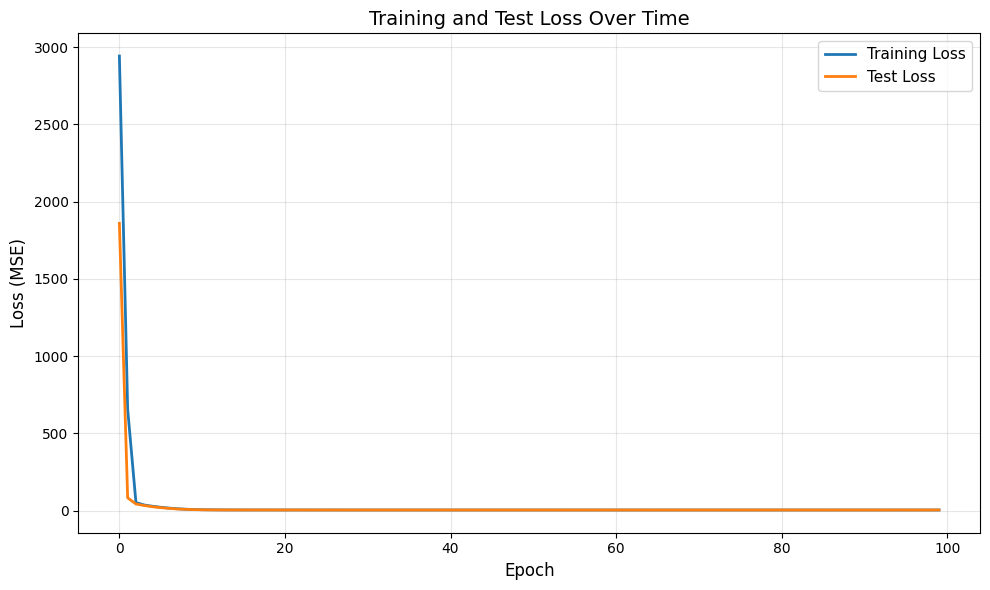

Final Training Loss: 4.2263
Final Test Loss: 4.8714


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## 9. Model Evaluation

Evaluate the model on the test set and visualize predictions vs actual values.

In [15]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

Model Performance on Test Set:
Mean Squared Error (MSE):  4.8806
Root Mean Squared Error (RMSE): 2.2092
Mean Absolute Error (MAE): 1.7766
R² Score: 0.9868

Interpretation:
On average, predictions are off by $177656.11
Model explains 98.68% of the variance in house prices


## 10. Visualize Predictions

Compare predicted values with actual values to see how well the model performs.

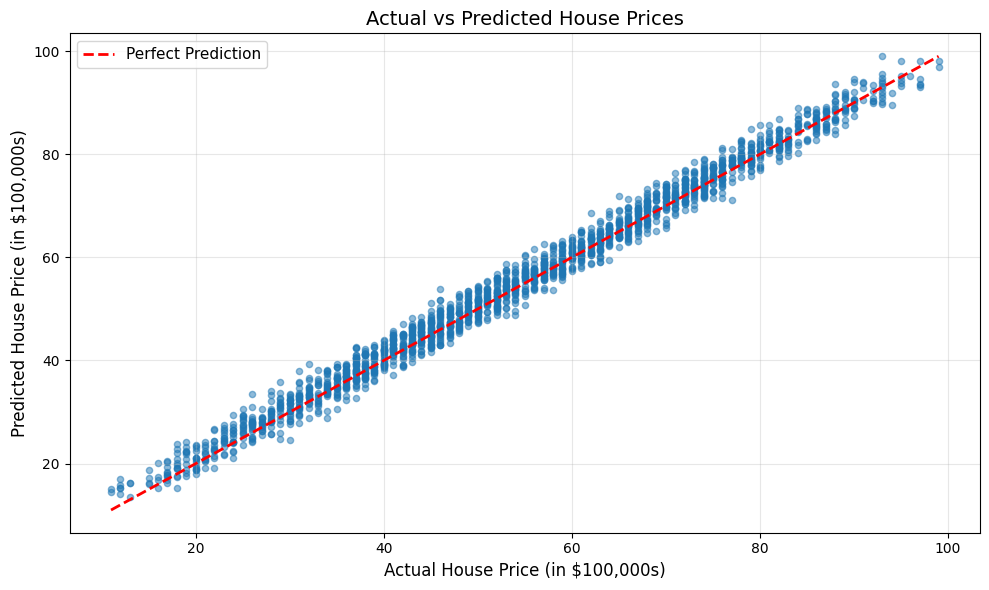


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
$ 5,100,000 | $ 5,535,748 | $  -435,748
$ 2,000,000 | $ 2,365,626 | $  -365,626
$ 4,600,000 | $ 4,859,850 | $  -259,850
$ 2,800,000 | $ 3,205,868 | $  -405,868
$ 4,100,000 | $ 4,321,820 | $  -221,820
$ 5,900,000 | $ 5,916,727 | $   -16,727
$ 4,800,000 | $ 4,673,848 | $   126,152
$ 8,700,000 | $ 8,795,664 | $   -95,664
$ 3,700,000 | $ 3,816,498 | $  -116,498
$ 7,300,000 | $ 7,342,092 | $   -42,092


In [16]:
# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Price (in $100,000s)', fontsize=12)
plt.ylabel('Predicted House Price (in $100,000s)', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0] * 100000
    predicted = y_pred[i][0] * 100000
    diff = actual - predicted
    print(f"${actual:>10,.0f} | ${predicted:>10,.0f} | ${diff:>10,.0f}")

## 11. Save the Model (Optional)

Save the trained model for future use.

In [11]:
# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


## Summary

### What We Learned:

1. **Data Preparation**: Loaded, split, and normalized data
2. **PyTorch Tensors**: Converted data to PyTorch format
3. **DataLoader**: Created batches for efficient training
4. **Neural Network**: Built a simple feedforward network
5. **Training Loop**: Implemented forward/backward passes
6. **Evaluation**: Assessed model performance with metrics
7. **Visualization**: Plotted training progress and predictions

### Key Concepts:

- **Forward Pass**: Input → Hidden Layers → Output
- **Loss Function**: Measures prediction error (MSE)
- **Backward Pass**: Computes gradients via backpropagation
- **Optimizer**: Updates weights to minimize loss (Adam)
- **Epochs**: Complete passes through training data

### Next Steps:

Try experimenting with:
- Different network architectures (more/fewer layers)
- Different activation functions
- Different optimizers (SGD, RMSprop)
- Learning rate scheduling
- Dropout for regularization